## C S 329E HW 6

# KNN 

## Jeremy Ulfohn / Anthony Roth-Giacinto

For this week's homework we are going explore one new classification technique:

  - k nearest neighbors

We are using a different version of the Melbourne housing data set, to predict the housing type as one of three possible categories:

  - 'h' house
  - 'u' duplex
  - 't' townhouse

At the end of this homework, I expect you to understand how to build and use a kNN model, and practice your data cleaning and data preparation skills. 

In [1]:
# These are the libraries you will use for this assignment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import calendar
%matplotlib inline

# Starting off loading a training set
df_melb = pd.read_csv('https://gist.githubusercontent.com/yanyanzheng96/81b236aecee57f6cf65e60afd865d2bb/raw/56ddb53aa90c26ab1bdbfd0b8d8229c8d08ce45a/melb_data_train.csv')

# INPUT: year, month = y, m
# OUTPUT: days in that month
def getDays(y, m):
    month_arr = calendar.monthcalendar(y, m)
    month = []
    for week in month_arr:
        new = list(filter(lambda a: a != 0, week))
        month.extend(new)
    return len(month)

df_melb

,Rooms,Type,Price,Date,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt
0,2,h,399000,7/5/16,8.7,3032,1,1.0,904,53.0,1985.0
1,3,h,1241000,28/08/2016,13.9,3165,1,1.0,643,NaN,NaN
2,2,u,550000,8/7/17,3.0,3067,1,1.0,1521,NaN,NaN
3,3,u,691000,24/06/2017,8.4,3072,1,1.0,170,NaN,NaN
4,2,u,657500,19/11/2016,4.6,3122,1,1.0,728,73.0,1965.0
...,...,...,...,...,...,...,...,...,...,...,...
495,2,t,710000,29/07/2017,7.2,3184,1,1.0,0,NaN,1980.0
496,2,u,446000,16/04/2016,8.0,3040,1,1.0,0,NaN,NaN
497,3,h,887000,8/4/17,9.2,3058,1,2.0,560,NaN,NaN
498,3,h,1365000,7/5/16,8.0,3040,1,1.0,754,NaN,NaN


## Q1 - Fix a column of data to be numeric
If we inspect our dataframe, `df_melb` using the `dtypes` method, we see that the column "Date" is an object.  However, we think this column might contain useful information so we want to convert it to [seconds since epoch](https://en.wikipedia.org/wiki/Unix_time). Use only the exiting imported libraries to create a new column "unixtime". Be careful, the date strings in the file might have some non-uniform formatting that you have to fix first.  Print out the min and max epoch time to check your work.  Drop the original "Date" column. Please use the python [reference for time](https://docs.python.org/3/library/time.html) to help you do the string to Unix time conversion. 

In [2]:
# normalize date accepts the date string as shown in the df_melb 'Date' column,
# and returns a data in a standarized format
# DATE FORMAT: DD/MM/YYYY or D/M/YY
def standardize_date(d):
    # get current time
    ticks = time.time()

    datelist = d.split("/") # split on dashes
    total_days = int(datelist[0]) + getDays(int(datelist[2]), int(datelist[1]))
    # subtract time SINCE d from current time
    fixed_time = ticks - total_days * 3600 * 24
    return fixed_time


    


    


    
    # Your code here

In [3]:
df_melb['Date'] = df_melb['Date'].apply( lambda x : standardize_date(x))
df_melb = df_melb.rename(columns={'Date': 'unixtime'}) # effectively drop 'Date' col

# values are floats, so use {:f} instead of {:d}
print("The min unixtime is {:f} and the max unixtime is {:f}".format(df_melb['unixtime'].min(),df_melb['unixtime'].max()))

The min unixtime is 1628827174.836147 and the max unixtime is 1631332774.841225


## Q2 Use Imputation to fill in missing values
kNN doesn't work when the attributes are not valid for all of the attribute columns, so fill in all the missing values in `df_melb` with the mean of that column.  Save the mean of each column in a dictionary, `dict_imputation`, whose key is the attribute column name, so we can apply the same imputation to the test set later. Show your `dict_imputation` dictionary and the head of your `df_melb` dataframe.  The target classfication (aka the class label) is stored in the column `'Type'`, so we are going to define a variable target_col so we can reference the target_col using a variable. (hint: during imputation you skip the target column)

In [4]:
target_col = 'Type' # DEFAULT; to be used to reference target col with a variable

dict_imputation = {} # save col means in a dictionary
# fill in dict
for col in list(df_melb.columns):
    if col == 'Type':
        continue
    else:
        dict_imputation[col] = df_melb[col].mean()

    # in same loop, fill in NaN with calculated mean (using .fillna() )
    df_melb = df_melb.fillna({col:dict_imputation[col]})

# test
df_melb 


,Rooms,Type,Price,unixtime,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt
0,2,h,399000,1.630814e+09,8.7,3032,1,1.0,904,53.0000,1985.000000
1,3,h,1241000,1.629000e+09,13.9,3165,1,1.0,643,121.7832,1970.941748
2,2,u,550000,1.630728e+09,3.0,3067,1,1.0,1521,121.7832,1970.941748
3,3,u,691000,1.629432e+09,8.4,3072,1,1.0,170,121.7832,1970.941748
4,2,u,657500,1.629864e+09,4.6,3122,1,1.0,728,73.0000,1965.000000
...,...,...,...,...,...,...,...,...,...,...,...
495,2,t,710000,1.628914e+09,7.2,3184,1,1.0,0,121.7832,1980.000000
496,2,u,446000,1.630123e+09,8.0,3040,1,1.0,0,121.7832,1970.941748
497,3,h,887000,1.630814e+09,9.2,3058,1,2.0,560,121.7832,1970.941748
498,3,h,1365000,1.630814e+09,8.0,3040,1,1.0,754,121.7832,1970.941748


In [5]:
dict_imputation

{'Bathroom': 1.44,
 'BuildingArea': 121.7832,
 'Car': 1.503006012024048,
 'Distance': 10.524599999999985,
 'Landsize': 638.91,
 'Postcode': 3113.122,
 'Price': 932558.7,
 'Rooms': 2.71,
 'YearBuilt': 1970.9417475728155,
 'unixtime': 1630062694.835085}

In [6]:
df_melb.head()

,Rooms,Type,Price,unixtime,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt
0,2,h,399000,1.630814e+09,8.7,3032,1,1.0,904,53.0000,1985.000000
1,3,h,1241000,1.629000e+09,13.9,3165,1,1.0,643,121.7832,1970.941748
2,2,u,550000,1.630728e+09,3.0,3067,1,1.0,1521,121.7832,1970.941748
3,3,u,691000,1.629432e+09,8.4,3072,1,1.0,170,121.7832,1970.941748
4,2,u,657500,1.629864e+09,4.6,3122,1,1.0,728,73.0000,1965.000000


## Q3 Normalize all the attributes to be between [0,1]
Normalize all the attribute columns in `df_melb` so they have a value between zero and one (inclusive). Save the (min,max) tuple used to normalize to a dictionary, `dict_normalize`, so we can apply it to the test set later.  The dataframe `df_melb` is now your "model" that you can use to classify new data points. (hint: during normalization you skip the class label column)

In [7]:
# normalize ALL attribute columns to be in [0,1]
# save (min, max) tuple in dictionary

dict_normalize = dict()
for col in df_melb.columns:
    if col == 'Type': # skip class label column of 'Type', as above
        continue
    else:
        # populate dictionary w { col_name : (min, max) }
        dict_normalize[col] = (df_melb[col].min(), df_melb[col].max())
        df_melb[col] = (df_melb[col] - df_melb[col].min()) / (df_melb[col].max() - df_melb[col].min())


In [8]:
dict_normalize

{'Bathroom': (0, 4),
 'BuildingArea': (0.0, 475.0),
 'Car': (0.0, 4.0),
 'Distance': (0.7, 47.3),
 'Landsize': (0, 41400),
 'Postcode': (3002, 3810),
 'Price': (291000, 5020000),
 'Rooms': (1, 6),
 'YearBuilt': (1890.0, 2015.0),
 'unixtime': (1628827174.8361473, 1631332774.8412247)}

In [9]:
df_melb.head()

,Rooms,Type,Price,unixtime,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt
0,0.2,h,0.022838,0.793103,0.171674,0.037129,0.25,0.25,0.021836,0.111579,0.760000
1,0.4,h,0.200888,0.068966,0.283262,0.201733,0.25,0.25,0.015531,0.256386,0.647534
2,0.2,u,0.054768,0.758621,0.049356,0.080446,0.25,0.25,0.036739,0.256386,0.647534
3,0.4,u,0.084584,0.241379,0.165236,0.086634,0.25,0.25,0.004106,0.256386,0.647534
4,0.2,u,0.077501,0.413793,0.083691,0.148515,0.25,0.25,0.017585,0.153684,0.600000


## Q4 Load in the Test data and prep it for classification
Everything we did to our "train" set, we need to now do in our "test" set. 

In [10]:
df_test = pd.read_csv('https://gist.githubusercontent.com/yanyanzheng96/c3d53303cebbd986b166591d19254bac/raw/94eb3b2d500d5f7bbc0441a8419cd855349d5d8e/melb_data_test.csv')

In [11]:
# Your code here to fix date
df_test['Date'] = df_test['Date'].apply( lambda x : standardize_date(x))
df_test = df_test.rename(columns={'Date': 'unixtime'}) # effectively drop 'Date' col

# values are floats, so use {:f} instead of {:d}
print("The min unixtime is {:f} and the max unixtime is {:f}".format(df_test['unixtime'].min(),df_test['unixtime'].max()))

The min unixtime is 1628827175.770000 and the max unixtime is 1631332775.770871


In [12]:
# Your code here for imputation - must use dictionary from above! 
for col in list(df_test.columns):
    if col == 'Type':
        continue
    else:
        df_test = df_test.fillna({col:dict_imputation[col]})       

In [13]:
# Your code here for scaling - must use dictionary from above!
for col in df_test.columns:
    if col == 'Type': # skip class label column of 'Type', as above
        continue
    else:
        #min = dict_normalize[col][0]
        #max = dict_normalize[col][1]
        df_test[col] = (df_test[col] - dict_normalize[col][0]) / (dict_normalize[col][1] - dict_normalize[col][0])

df_test.head()


,Rooms,Type,Price,unixtime,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt
0,0.4,h,0.174455,1.000000,0.369099,0.235149,0.25,0.5,0.014734,0.256386,0.647534
1,0.4,h,0.367731,0.068966,0.225322,0.227723,0.50,0.5,0.008841,0.256386,0.647534
2,0.4,h,0.251427,0.827587,0.214592,0.228960,0.50,0.5,0.016836,0.301053,0.280000
3,0.4,u,0.192958,0.103449,0.248927,0.202970,0.50,0.5,0.007512,0.267368,0.880000
4,0.4,h,0.052654,0.965518,0.300429,0.034653,0.50,0.5,0.008527,0.284211,0.968000


## Q5 Write the kNN classifier function
Your function `knn_class`, should take five parameters, the training dataframe (that includes the target column), the hyper parameter `k`, the name of the target column, a single observation row (a series or attributes the same length as the attributes in `df_train`) of the test dataframe, and a boolean `use_weighted_vote`.  When `use_weighted_vote` is set to true, use weighted voting, otherwise use majority voting. We are assuming that the parameter `df_train` contains all of the attributes, and the target class in the same dataframe. The function returns the predicted target classification for that observation. To find the distance between the single observation and the training data frame you should use the [L2 norm](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html)

In [14]:
# function to get euclidean distance between two points (numeric)
def euclidean(p1, p2):
    # use L2 norm to find distance
    distance = np.linalg.norm(p1-p2)
    return distance


In [29]:
from scipy.stats import mode # import required module

# k - hyperparameter
# target_col = 'Type' (predefined) 
# observation = single row of attributes from df_train
# use_weighted_vote = boolean
attr_labels = ['Rooms', 'Price', 'unixtime', 'Distance', 'Postcode', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt']


def knn_class(df_train, k, target_col, observation, use_weighted_vote):

    # first, separate df_train into X_train and y_train
    y_train = df_train[target_col] # series type
    X_train = df_train.drop(columns=[target_col])
    # UPDATE: keep X_train as a df, NOT numpy array
    # X_train = X_train.to_numpy()

    # 1) convert observation Series to NumPy
    # 2) remove class labels from observation row of test dataframe
    # UPDATE: observation already IS numpy, in our use of it in Q6
    observation_label = observation[1]
    observation = np.delete(observation, 1)

    # create array to keep track of (distance, label)
    point_distances = []
    
    
    
    
    X_train = X_train.to_numpy()
    # OUTER: iterate through each value in observ. row
    for curr_idx, other_attr in enumerate(X_train): # enumerate the pd.Series object
        distance = euclidean(other_attr, observation) # get distance between the two
        point_distances.append((float(distance), y_train[curr_idx])) # append (dist, Type)


    # c = 0 # to count which column we're on
    # for obs_attr in observation:

    #     # INNER: iterate through each row AT given attribute col of observation
    #     for curr_idx, other_attr in enumerate(X_train[attr_labels[c]]): # enumerate the pd.Series object
    #         distance = euclidean(other_attr, obs_attr) # get distance between the two
    #         point_distances.append((float(distance), y_train[curr_idx])) # append (dist, Type)
    #     # move on to next column
    #     c += 1    




    # at this point, we have the list of (dist, Type)
    # sort array while preserving indices, keep only first k nearest neighbors
    # tup.sort(key = lambda x: x[0]) to sort by first item
    #dist = point_distances.sort(key = lambda x: x[0])[:k]
    dist = sorted(point_distances)[:k] # in ascending order

    # labels of the k datapoints from above
    # labels = y_train[dist]
    labels = [d[1] for d in dist]

    # majority voting if weighted == False, using scipy.stats.mode()
    if not use_weighted_vote:
        freq_h = 0
        freq_u = 0
        freq_t = 0

        for d in dist: # simply count the k nearest, one-by-one
            if d[1] == 'h':
                freq_h += 1
            elif d[1] == 'u':
                freq_u += 1
            else:
                freq_t += 1
        
        final_freq = [freq_h, freq_u, freq_t]
        if max(final_freq) == freq_h:
            return 'h'
        elif max(final_freq) == freq_u:
            return 'u'
        else: # else 't'
            return 't'
    # else weighted voting
    else:
        # initialize weighted sums of each group
        freq_h = 0
        freq_u = 0
        freq_t = 0
              
        for d in dist: # dist contains tuples of (distance, classLabel)
            if d[1] == 'h':
                freq_h += d[0] * (1 / d[0] ** 2) # apply weight formula times d
            elif d[1] == 'u':
                freq_u += d[0] * (1 / d[0] ** 2)
            elif d[1] == 't':
                freq_t += d[0] * (1 / d[0] ** 2)
        
        final_freq = [freq_h, freq_u, freq_t]
        if max(final_freq) == freq_h:
            return 'h'
        elif max(final_freq) == freq_u:
            return 'u'
        else: # else 't'
            return 't'


## Q6 Compute the accuracy using different k values
For each value of $k$ in the set $\{1,3,13,25,50,100\}$ calculate the class prediction for each oberservation in the test set, and the overall accuracy of the classifier.  Plot the accuracy as a function of $k$ when `use_weighted_vote` is `True` and when `use_weighted_vote` is `False`.

Which value of $k$ would you choose, and would you use weighted voting or majority voting?

Note, this took 20 seconds for me on Google Colab. 

Accuracies for majority voting, k = {1,3,13,25,50,100} respectively
[0.7, 0.68, 0.67, 0.71, 0.7, 0.65] 

Accuracies for weighted voting, k = {1,3,13,25,50,100} respectively
[0.7, 0.67, 0.69, 0.69, 0.68, 0.66]


Text(0, 0.5, 'Accuracy Level')

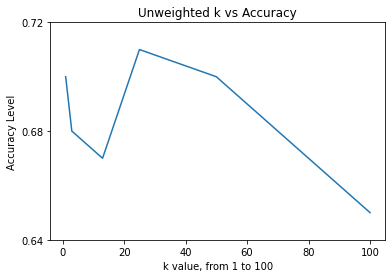

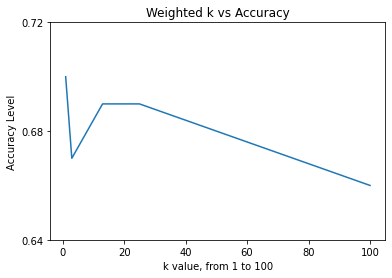

In [40]:
poss_k = [1,3,13,25,50,100] # possible k's
acc_k_majority = list(np.zeros(len(poss_k))) # Accuracy for each value of k using majority voting
acc_k_weighted = list(np.zeros(len(poss_k))) # Accuracy for each value of k using weighted voting

res_m = ''
res_w = ''

total = 0

#df_test = df_test.to_numpy() CHANGEME AT END
for observation in df_test: # each observation is an ndArray
    total += 1
    for idx, k in enumerate(poss_k):
        
        res_m = knn_class(df_melb, k, 'Type', observation, False)
        res_w = knn_class(df_melb, k, 'Type', observation, True)
        
        if res_m == observation[1]:
            acc_k_majority[idx] += 1     
        if res_w == observation[1]:
            acc_k_weighted[idx] += 1



for idx, val in enumerate(acc_k_majority):
    acc_k_majority[idx] = val / total
for idx, val in enumerate(acc_k_weighted):
    acc_k_weighted[idx] = val / total



print("Accuracies for majority voting, k = {1,3,13,25,50,100} respectively")       
print(acc_k_majority, "\n")
print("Accuracies for weighted voting, k = {1,3,13,25,50,100} respectively")
print(acc_k_weighted)

fig,ax = plt.subplots(1)

# create some x data and some integers for the y axis
k_m = np.array([1,3,13,25,50,100])
accuracy_m = acc_k_majority

# plot the data
ax.plot(k_m,accuracy_m)

# tell matplotlib which yticks to plot 
ax.set_yticks([0.64, 0.68, 0.72])
ax.set_title("Unweighted k vs Accuracy")
ax.set_xlabel("k value, from 1 to 100")
ax.set_ylabel("Accuracy Level")


# ~~~~~~~~~~~~~~~~~ weighted ~~~~~~~~~~~~~~~~~~
fig,ax = plt.subplots(1)

# create some x data and some integers for the y axis
k_w = np.array([1,3,13,25,50,100])
accuracy_w = acc_k_weighted

# plot the data
ax.plot(k_w,accuracy_w)

# tell matplotlib which yticks to plot 
ax.set_yticks([0.64, 0.68, 0.72])
ax.set_title("Weighted k vs Accuracy")
ax.set_xlabel("k value, from 1 to 100")
ax.set_ylabel("Accuracy Level")

➡️ I would choose k = 25 and weighted voting due to the nature of some of the attributes being discrete (i.e. Rooms, etc, which may lead to multiple equal-distanced neighbors) and the number of observations being even while maintaining a consistently higher accuracy compared to other k values, as evidenced by the plots above. ⬅️ 